In [7]:
pip install PyMuPDF


   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   - -------------------------------------- 0.1/3.2 MB 2.0 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/3.2 MB 5.6 MB/s eta 0:00:01
   ---------------------------- ----------- 2.3/3.2 MB 16.3 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 17.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.4 MB ? eta -:--:--
   ------------- -------------------------- 4.1/12.4 MB 86.1 MB/s eta 0:00:01
   ---------------- ----------------------- 5.2/12.4 MB 81.6 MB/s eta 0:00:01
   ------------------------------ --------- 9.3/12.4 MB 66.2 MB/s eta 0:00:01
   ---------------------------------------  12.2/12.4 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------- 12.4/12.4 MB 54.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas numpy scikit-learn matplotlib seaborn transformers PyMuPDF Flask


     ---------------------------------------- 0.0/43.8 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.8 kB 682.7 kB/s eta 0:00:01
     -------------------------------------- 43.8/43.8 kB 541.5 kB/s eta 0:00:00
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/9.1 MB 9.4 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/9.1 MB 22.7 MB/s eta 0:00:01
   --------------------- ------------------ 4.9/9.1 MB 34.7 MB/s eta 0:00:01
   ----------------------------- ---------- 6.7/9.1 MB 39.1 MB/s eta 0:00:01
   ---------------------------------------  9.1/9.1 MB 41.4 MB/s eta 0:00:01
   ---------------------------------------- 9.1/9.1 MB 38.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/401.7 kB ? eta -:--:--
   ----------- 

Step 1: Load The Data

First, I load the CSV files into Pandas DataFrame

In [15]:
import pandas as pd
import re
import numpy as np
from sklearn.impute import SimpleImputer

# Load CSV files
datasets = {
    'borough_recent': 'MPS Borough Level Crime (most recent 24 months).csv',
    'borough_historical': 'MPS Borough Level Crime (Historical).csv',
    'ward_recent': 'MPS Ward Level Crime (most recent 24 months).csv',
    'ward_historical': 'MPS Ward Level Crime (Historical).csv',
    'lsoa_recent': 'MPS LSOA Level Crime (most recent 24 months).csv',
    'lsoa_historical': 'MPS LSOA Level Crime (Historical).csv',
    'reported_data': 'reported.csv',
    'intentional_homicides': 'SYB63_328_202009_Intentional Homicides and Other Crimes.csv'
}

# Preprocess Function
def preprocess_crime_data(df):
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Clean text columns
    text_columns = ['majortext', 'minortext', 'wardname', 'lookup_boroughname']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().str.replace(r'[^\w\s]', '').str.strip()
    
    # Convert date columns
    date_columns = [col for col in df.columns if re.match(r'\d{6}', col)]
    if date_columns:
        # Convert and consolidate date columns
        date_df = df[date_columns].apply(pd.to_datetime, format='%Y%m', errors='coerce')
        df['date'] = date_df.bfill(axis=1).iloc[:, 0]
        df.drop(columns=date_columns, inplace=True)
    
    # Impute missing values for numerical data
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        imputer_num = SimpleImputer(strategy='median')
        df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])
    
    # Impute missing values for categorical data
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])
    
    df = df.drop_duplicates()
    return df

# Apply preprocessing to all datasets
cleaned_datasets = {name: preprocess_crime_data(pd.read_csv(path)) for name, path in datasets.items()}

# Example: Inspect the cleaned dataset
for name, df in cleaned_datasets.items():
    print(f"{name}: {df.shape}")
    print(df.head())






borough_recent: (999, 4)
                   majortext                        minortext  \
0  arson and criminal damage                            arson   
1  arson and criminal damage                  criminal damage   
2                   burglary           burglary - residential   
3                   burglary  burglary business and community   
4                   burglary           burglary in a dwelling   

            boroughname date  
0  Barking and Dagenham  NaT  
1  Barking and Dagenham  NaT  
2  Barking and Dagenham  NaT  
3  Barking and Dagenham  NaT  
4  Barking and Dagenham  NaT  
borough_historical: (931, 4)
                   majortext                        minortext  \
0  arson and criminal damage                            arson   
1  arson and criminal damage                  criminal damage   
2                   burglary  burglary business and community   
3                   burglary           burglary in a dwelling   
4              drug offences              po

Explanation

Load CSV files: Loads the datasets into a dictionary.
    
Standardize column names: Converts all column names to lowercase and replaces spaces with underscores for consistency.
    
Clean text columns: Cleans text columns by converting them to lowercase, removing non-alphanumeric characters, and stripping whitespace.
    
Convert date columns: Converts date columns to datetime format and consolidates them into a single 'date' column using backfilling to handle missing 

values. This avoids the performance warning by modifying the DataFrame in fewer steps.
    
Impute missing values for numerical data: Uses SimpleImputer with the median strategy to fill missing numerical values.
    
Impute missing values for categorical data: Uses SimpleImputer with the most frequent strategy to fill missing categorical values.
    
Remove duplicates: Ensures data integrity by removing duplicate rows.

By using bfill(axis=1).iloc[:, 0] and dropping the original date columns all at once, this method should handle the performance warning better.

Extract and Preprocess Text from the PDF

Extract text data from the PDF file and clean it for further analysis.

In [16]:
import fitz  # PyMuPDF

# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text = ""
    document = fitz.open(file_path)
    for page_num in range(document.page_count):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

# Extract text from the PDF
pdf_text = extract_text_from_pdf('fra-2024-fundamental-rights-report-2024_en.pdf')

# Clean the extracted text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W', ' ', text)   # Remove special characters
    text is text.lower().strip()       # Convert to lower case and strip whitespaces
    return text

cleaned_pdf_text = clean_text(pdf_text)



Explanation:

  Extract text: Reads the PDF file and extracts text from each page
   Clean text: Standardizes the extracted text by removing extra spaces, special characters, and converting to lowercase.

Exploratory Data Analysis (EDA)

Visualize the data to understand distributions and trends.


For Datasets with majortext and date

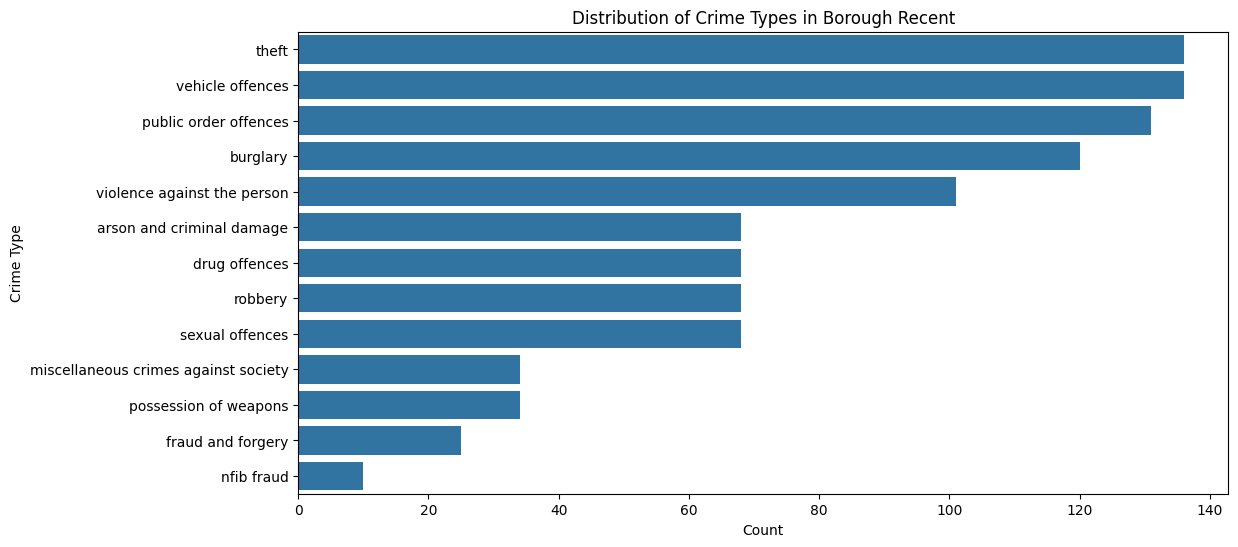

Column 'date' not found in dataset: Crime Counts Over Time in Borough Recent


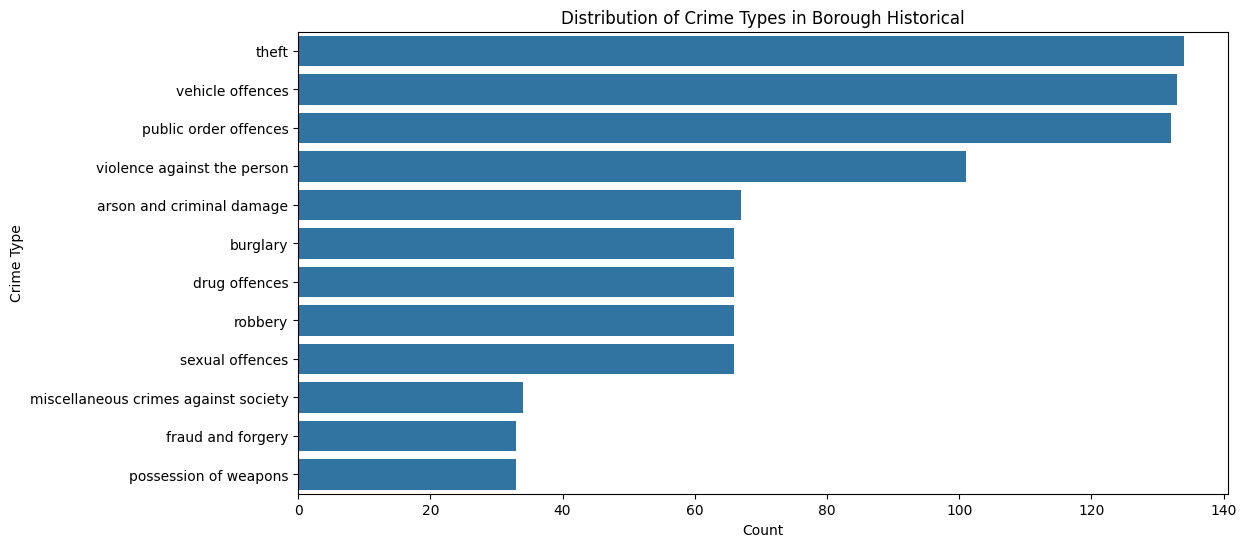

Column 'date' not found in dataset: Crime Counts Over Time in Borough Historical


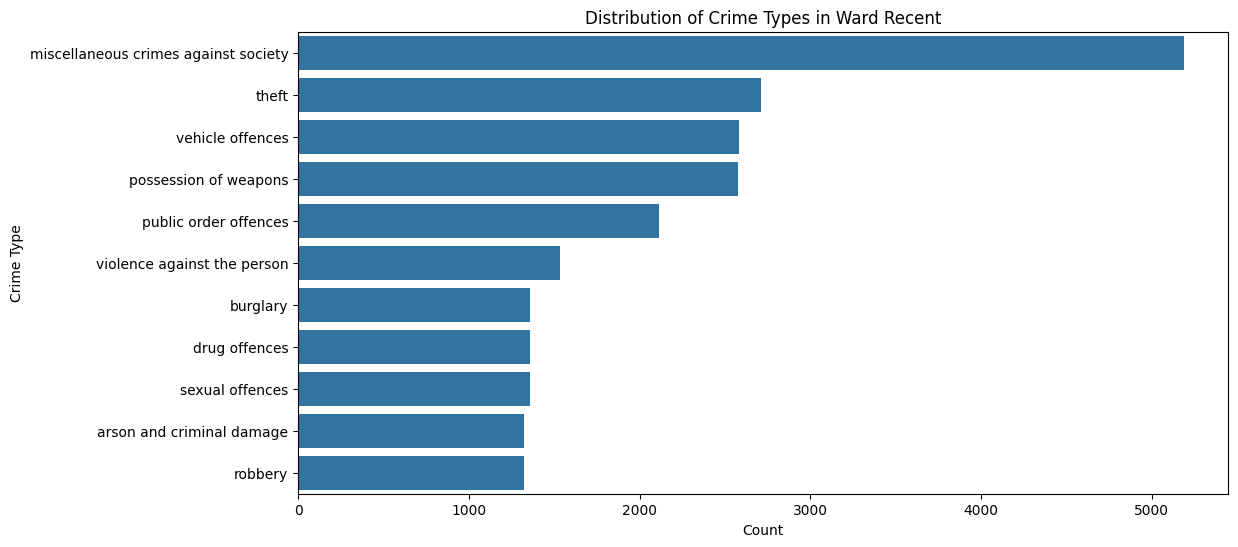

Column 'date' not found in dataset: Crime Counts Over Time in Ward Recent


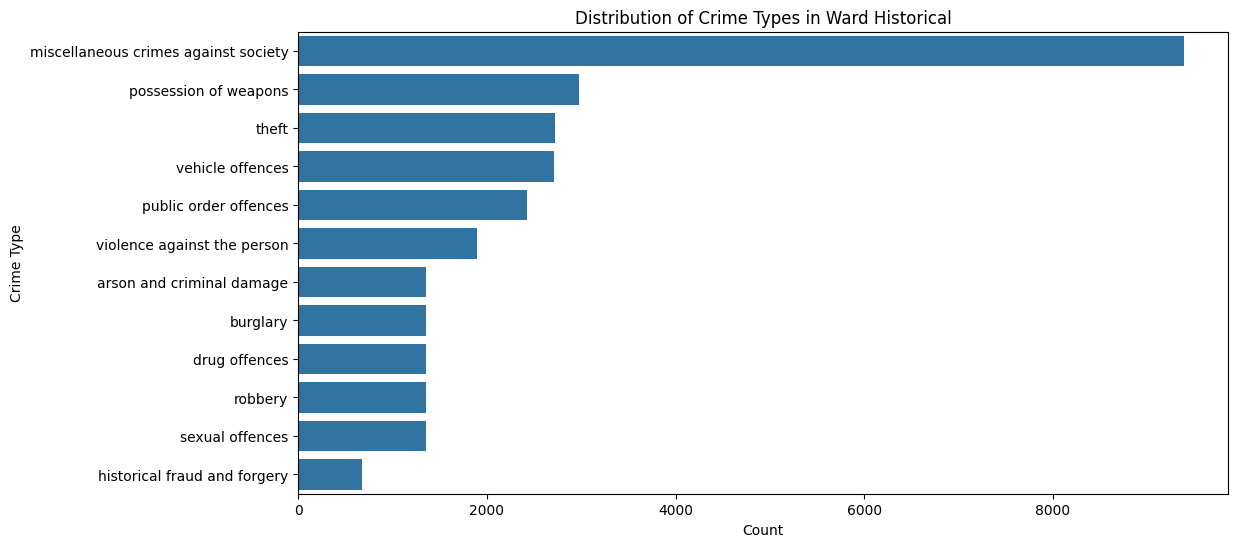

Column 'date' not found in dataset: Crime Counts Over Time in Ward Historical
Column 'majortext' not found in dataset: Distribution of Crime Types in Lsoa Recent
Column 'date' not found in dataset: Crime Counts Over Time in Lsoa Recent
Column 'majortext' not found in dataset: Distribution of Crime Types in Lsoa Historical
Column 'date' not found in dataset: Crime Counts Over Time in Lsoa Historical
Column 'majortext' not found in dataset: Distribution of Crime Types in Reported Data
Column 'date' not found in dataset: Crime Counts Over Time in Reported Data
Column 'majortext' not found in dataset: Distribution of Crime Types in Intentional Homicides
Column 'date' not found in dataset: Crime Counts Over Time in Intentional Homicides


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution of crime types
def plot_crime_distribution(df, title):
    if 'majortext' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(y='majortext', data=df, order=df['majortext'].value_counts().index)
        plt.title(title)
        plt.xlabel('Count')
        plt.ylabel('Crime Type')
        plt.show()
    else:
        print(f"Column 'majortext' not found in dataset: {title}")

# Function to plot time series of crime counts
def plot_crime_timeseries(df, title):
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
        df.groupby('date').size().plot(figsize=(12, 6))
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Number of Crimes')
        plt.show()
    else:
        print(f"Column 'date' not found in dataset: {title}")

# Plot for each dataset
for name, df in cleaned_datasets.items():
    plot_crime_distribution(df, f'Distribution of Crime Types in {name.replace("_", " ").title()}')
    plot_crime_timeseries(df, f'Crime Counts Over Time in {name.replace("_", " ").title()}')




In [19]:
import pandas as pd

# Load the datasets
reported_data = pd.read_csv('reported.csv')
intentional_homicides = pd.read_csv('SYB63_328_202009_Intentional Homicides and Other Crimes.csv')

# Display the first few rows and the columns of the datasets to verify the presence of 'majortext' and 'date'
print("Reported Data:")
print(reported_data.head())
print("Columns:", reported_data.columns.tolist())

print("\nIntentional Homicides Data:")
print(intentional_homicides.head())
print("Columns:", intentional_homicides.columns.tolist())


Reported Data:
   Year  crimes.total  crimes.penal.code  crimes.person  murder  assault  \
0  1950          2784               2306            120       1      105   
1  1951          3284               2754            125       1      109   
2  1952          3160               2608            119       1      104   
3  1953          2909               2689            119       1      105   
4  1954          3028               2791            126       1      107   

   sexual.offenses  rape  stealing.general  burglary  ...  vehicle.theft  \
0               40     5              1578       295  ...            NaN   
1               45     6              1899       342  ...            NaN   
2               39     4              1846       372  ...            NaN   
3               45     5              1929       361  ...            NaN   
4               41     5              1981       393  ...            NaN   

   out.of.vehicle.theft  shop.theft  robbery  fraud  criminal.damage  \